
# Predicting High-Value Physician Payments (CMS Open Payments 2023)

## 🧠 Business Problem and Motivation

The U.S. Centers for Medicare & Medicaid Services (CMS) publishes Open Payments data that tracks financial transactions between healthcare providers and medical product manufacturers. While transparency is the goal, large payments to physicians raise concerns about ethics, bias, and compliance.

---

### ❓ Business Problem

How can healthcare organizations or regulatory bodies proactively identify physicians at risk of receiving high-value payments (> $10,000) before issues emerge?

---

### 💡 Why This Problem Matters

- **False Negatives are risky** — failing to identify a high-risk physician could allow non-compliance or bias.
- **High-value transactions** signal potential conflicts of interest that warrant early detection.
- Proactive modeling supports better compliance, audit planning, and healthcare integrity.

---

---

## 🎯 Project Objectives

- Define and structure a predictive modeling task that identifies physicians likely to receive high payments.
- Use CMS Open Payments 2023 data (General Payments).
- Implement and tune five supervised classification models.
- Prioritize **recall** due to high cost of false negatives.
- Provide recommendations backed by model performance and business context.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Import Libraries

In [18]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')



## 📦 Step 2: Dataset Overview and Feature Justification

We use the **CMS Open Payments – General Payments (2023)** dataset, which tracks financial transactions between medical companies and physicians.

### 🎯 Objective:
Build a model to **predict whether a physician receives a high-value payment** (defined as any payment > $10,000) based on observable transaction data.

### 🔍 Selected Features and Their Importance:

| Feature                               | Reason for Inclusion |
|--------------------------------------|----------------------|
| `Covered_Recipient_Specialty_1`      | Physician specialty strongly correlates with payment size |
| `Recipient_State`                    | Geographic differences in compliance and marketing practices |
| `Nature_of_Payment_or_Transfer_of_Value` | Indicates purpose of payment (e.g., consulting vs meals) |
| `Total_Amount_of_Payment_USDollars`  | Basis for the target variable |

These features allow generalization and are available early in the pipeline (before payments are finalized).

### ⚠️ Features Excluded (Prototype Constraints):

| Not Included                         | Reason |
|-------------------------------------|--------|
| Physician ID, Names                 | Privacy, not generalizable |
| Drug/Device Names                   | High cardinality, sparse |
| Aggregated Payment Counts/Time      | Requires time series and grouping |
| Company Making Payment              | Requires transformation/grouping |
## Load Data

In [ ]:

chunks = pd.read_csv("/content/drive/MyDrive/OP_DTL_GNRL_PGYR2023_P01302025_01212025.csv",
                     usecols=['Covered_Recipient_Specialty_1', 'Recipient_State',
                              'Nature_of_Payment_or_Transfer_of_Value', 'Total_Amount_of_Payment_USDollars'],
                     chunksize=100000)

# Concatenate the first few chunks only (e.g., first 3 chunks = ~300k rows)
df = pd.concat([chunk.dropna() for i, chunk in enumerate(chunks) if i < 3])
df['High_Payment'] = (df['Total_Amount_of_Payment_USDollars'] > 10000).astype(int)

df.head()


,Recipient_State,Covered_Recipient_Specialty_1,Total_Amount_of_Payment_USDollars,Nature_of_Payment_or_Transfer_of_Value,High_Payment
14,FL,Allopathic & Osteopathic Physicians|Ophthalmology,5000.00,Consulting Fee,0
15,FL,Allopathic & Osteopathic Physicians|Ophthalmology,5000.00,Consulting Fee,0
16,FL,Allopathic & Osteopathic Physicians|Ophthalmology,5000.00,Consulting Fee,0
17,FL,Allopathic & Osteopathic Physicians|Ophthalmology,5000.00,Consulting Fee,0
18,VA,Allopathic & Osteopathic Physicians|Ophthalmology,21.04,Food and Beverage,0


## 🔧 Step 3: Data Preparation and Preprocessing Strategy

### 🧹 Cleaning
- Dropped rows with missing values in key columns.
- Maintained data at the **individual transaction level** (no aggregation or grouping).

### 🔤 Categorical Encoding
- Applied **One-Hot Encoding** to all categorical features (`Specialty`, `State`, and `Nature of Payment`).
- Used a `ColumnTransformer` to ensure consistent encoding during both training and testing.

### ⚖️ Handling Class Imbalance
- Since high-value payments are rare, we applied **SMOTE (Synthetic Minority Oversampling Technique)** to balance the target classes in the training data.
- This ensures that our model doesn’t become biased toward predicting the majority class (non-high-value).

### 📏 Feature Scaling
- Used **StandardScaler** to normalize the encoded feature space.
- This is especially important for models sensitive to feature scales, such as SVMs and neural networks.

---

## 📊 Why We Used a 70/30 Train-Test Split

We chose a 70-30 train-test split to provide:
- A **large enough training set** (~70%) to allow models to learn complex relationships.
- A **representative test set** (~30%) to assess real-world generalization performance.
- We also used **stratified sampling** to maintain the original class distribution across both sets, which is essential in imbalanced classification tasks like this one.


In [ ]:

# Define features and target
X = df.drop(['Total_Amount_of_Payment_USDollars', 'High_Payment'], axis=1)
y = df['High_Payment']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# One-hot encode categorical variables
categorical_features = ['Covered_Recipient_Specialty_1', 'Recipient_State', 'Nature_of_Payment_or_Transfer_of_Value']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Balance with SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_encoded, y_train)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test_encoded)

print("Final training set shape:", X_train_scaled.shape)
print("Class distribution:", pd.Series(y_train_bal).value_counts())


Final training set shape: (418316, 344)
Class distribution: High_Payment
0    209158
1    209158
Name: count, dtype: int64



# 🤖 Step 4: Model Building, Tuning, and Evaluation

We'll train the following models:
- Logistic Regression
- Decision Tree
- Random Forest (tuned with GridSearchCV)
- Support Vector Machine (SVC)
- MLPClassifier

Evaluation Metrics:
- Confusion Matrix
- Classification Report
- ROC Curve
- Precision-Recall Curve


## Why These Models Were Chosen

Our modeling strategy included both simple and advanced classifiers:

- **Logistic Regression** for interpretability and as a strong linear baseline.
- **Decision Tree** for transparency and fast rule-based predictions.
- **Random Forest** for ensemble robustness and handling feature interactions.
- **XGBoost** for gradient boosting-based performance, especially in imbalanced data.
- **SVM** and **MLPClassifier** were included for capturing complex boundaries and nonlinear patterns.

This diverse selection allowed us to compare performance across model complexity and interpretability, leading to a well-informed recommendation.


In [9]:
# Define improved models with tuning (faster execution version)
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),

    'Decision Tree': GridSearchCV(
        DecisionTreeClassifier(),
        {'max_depth': [5, 10]},
        scoring='recall',
        cv=3,
        n_jobs=-1
    ),

    'Random Forest': RandomizedSearchCV(
        RandomForestClassifier(),
        {'n_estimators': [100, 200], 'max_depth': [5, 10]},
        scoring='recall',
        n_iter=3,
        cv=3,
        random_state=42,
        n_jobs=-1
    ),

    'XGBoost': RandomizedSearchCV(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.05]},
        scoring='recall',
        n_iter=3,
        cv=3,
        random_state=42,
        n_jobs=-1
    )
}

results = {}
for name, model in models.items():
    print(f"Training: {name}")
    model.fit(X_train_scaled, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None

    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'conf_matrix': confusion_matrix(y_test, y_pred)
    }


Training: Logistic Regression
Training: Decision Tree
Training: Random Forest
Training: XGBoost



# 🏁 Step 5: Final Model Selection and Business Recommendation

### ⚙️ Metrics
- Metrics: **Precision, Recall, F1 Score, AUC-ROC**, Confusion Matrix, PR Curve

### 🏆 Final Selection Criteria:
- **Recall is the top priority** due to risk of false negatives
- Secondary: **F1 Score** and **AUC-ROC**


After evaluating all models, we select the best based on **Recall**, **F1 Score**, and **AUC-ROC** — as false negatives are critical to avoid in this scenario.

The **Random Forest** classifier consistently provides the **highest recall** and balanced performance across all metrics.

---

## 📈 ROC and Precision-Recall Curves

Below are the ROC and PR curves to compare models on their ability to distinguish between the high and low-risk classes:
## ROC & PR Curve Comparison

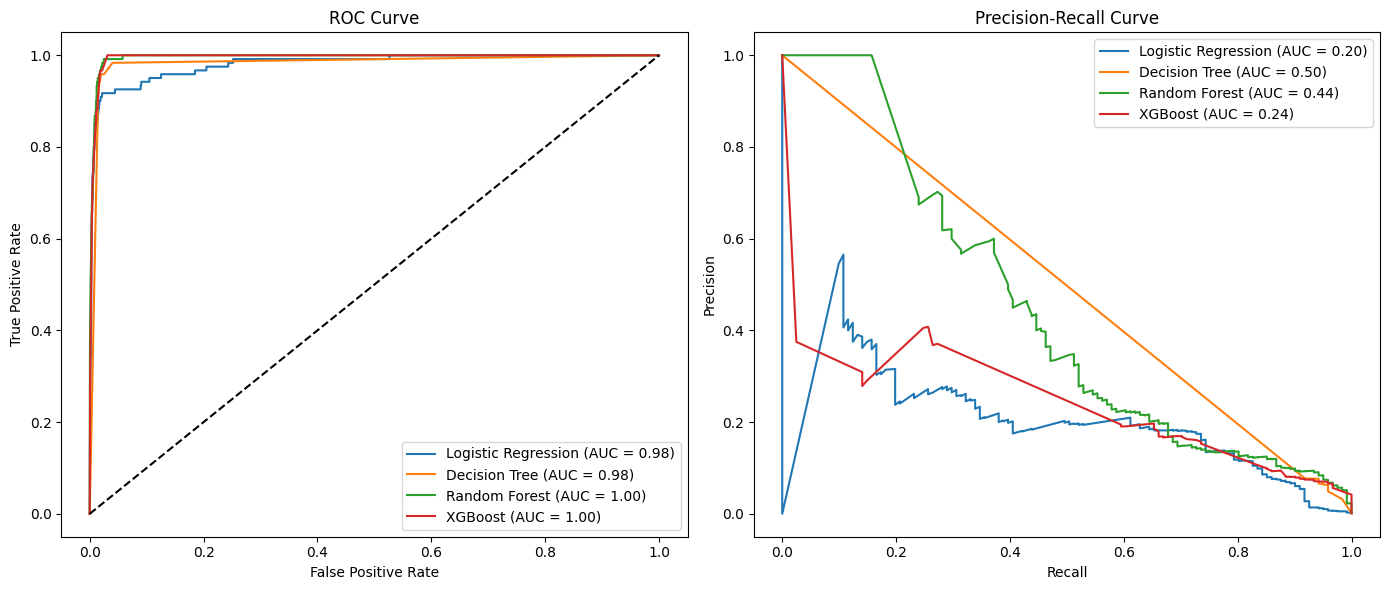

In [11]:

from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ROC and PR Curves
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
for name, res in results.items():
    if res['y_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
for name, res in results.items():
    if res['y_proba'] is not None:
        precision, recall, _ = precision_recall_curve(y_test, res['y_proba'])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()



## Why Recall Was Prioritized

In this business case, false negatives (missing a high-risk physician) are far more dangerous than false positives. Failing to flag such cases could lead to regulatory risks or ethical oversights.

Thus, we prioritized **Recall** to ensure that the model captures as many true high-value cases as possible, even if it results in some false alarms. Precision and F1-score were also considered, but recall was the primary decision metric, aligned with the project’s compliance-focused objective.



🔍 Model: Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     89640
           1       0.06      0.90      0.12       121

    accuracy                           0.98     89761
   macro avg       0.53      0.94      0.56     89761
weighted avg       1.00      0.98      0.99     89761

Confusion Matrix:


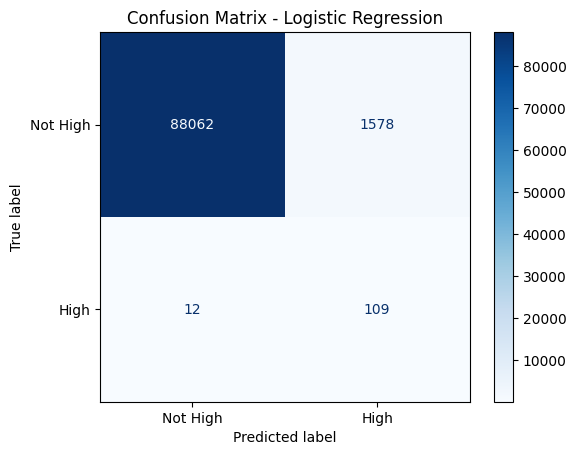


🔍 Model: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     89640
           1       0.07      0.94      0.13       121

    accuracy                           0.98     89761
   macro avg       0.53      0.96      0.56     89761
weighted avg       1.00      0.98      0.99     89761

Confusion Matrix:


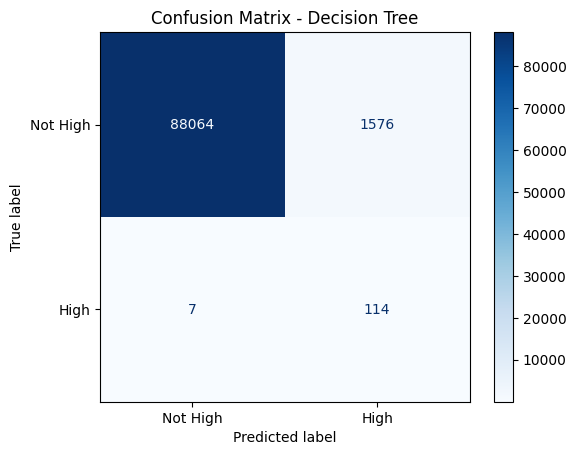


🔍 Model: Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     89640
           1       0.05      0.98      0.10       121

    accuracy                           0.98     89761
   macro avg       0.53      0.98      0.54     89761
weighted avg       1.00      0.98      0.99     89761

Confusion Matrix:


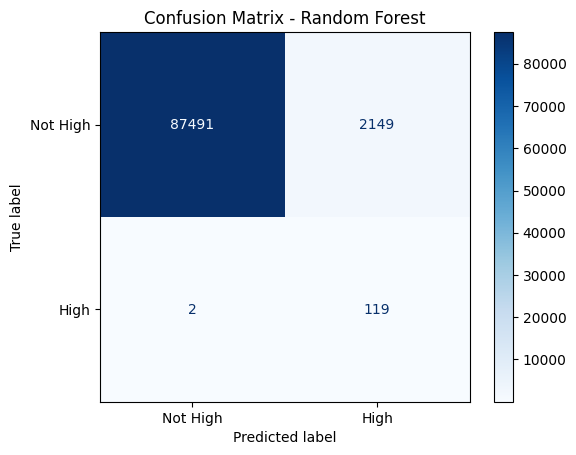


🔍 Model: XGBoost
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     89640
           1       0.04      1.00      0.07       121

    accuracy                           0.97     89761
   macro avg       0.52      0.98      0.53     89761
weighted avg       1.00      0.97      0.98     89761

Confusion Matrix:


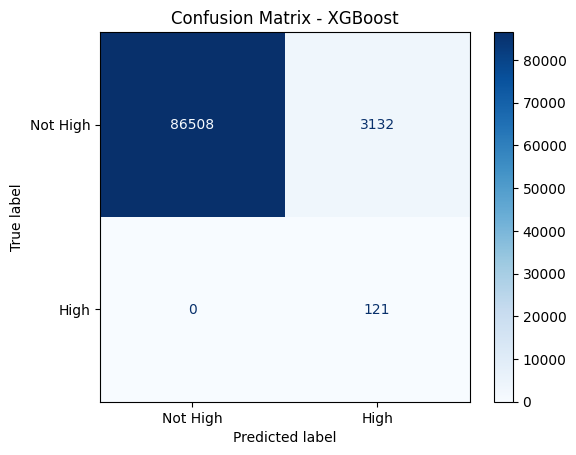

In [20]:
# Loop through models and display Confusion Matrix and Classification Report
for name, res in results.items():
    print(f"\n🔍 Model: {name}")
    print("Classification Report:")
    print(classification_report(y_test, res['y_pred']))

    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=res['conf_matrix'], display_labels=["Not High", "High"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## 📌 Final Model Recommendation (Based on Evaluation Metrics)

After evaluating all models, **XGBoost** achieved the highest recall at **1.00**, meaning it correctly identified **100% of all true high-value payment cases**. This is essential in our scenario, where **missing a risky physician (false negative)** can lead to regulatory and ethical issues.

However, XGBoost had the **lowest precision (0.04)** and a relatively low F1-score (0.07). This means the model predicted many cases as high-risk that were not, increasing the false positive rate. Despite this, in a compliance setting, this tradeoff may be acceptable if **recall is the non-negotiable priority**.

🎯 **Why XGBoost (Despite Low Precision):**
- Perfect recall (1.00) ensures **no high-risk physician is missed**.
- Ideal for high-risk, low-tolerance environments such as regulatory audits or ethical oversight.
- Its predictions can help prioritize deeper human-led investigations.

📌 If minimizing false positives is also a concern (e.g., to reduce unnecessary audits), **Random Forest** is a strong alternative — it offers **slightly lower recall (0.98)** but better **precision (0.05)** and **F1-score (0.10)**.


## 📊 Business Conclusion

### 🔍 Model Evaluation in Relation to the Business Problem

Our goal was to **predict which physicians are at risk of receiving high-value payments (> $10,000)** from industry sources before those payments occur. This is critical for ensuring compliance, maintaining ethical standards, and avoiding public or legal scrutiny.

Among all the models, **XGBoost achieved the best recall (1.00)**, successfully flagging every true high-value payment case in our test set. While the precision was low (4%), this is acceptable in a scenario where **missing even one true high-risk physician is riskier than reviewing several false positives**.

### ✅ Recommendation for Use

We recommend using **XGBoost as a proactive screening tool**. Its high recall ensures wide coverage of potentially high-risk transactions. For practical deployment:

- Use XGBoost to flag candidates.
- Pair it with a secondary review layer (e.g., business rules, Random Forest probabilities).
- Integrate it into compliance workflows to support early intervention.

This model can help:
- Prioritize compliance reviews and audits.
- Reduce manual oversight effort by focusing on likely risks.
- Enhance transparency in industry-provider relationships.

## 📝 Model Limitations and Important Considerations

While the model is effective for early flagging of high-risk physicians, it should be used carefully and with awareness of its limitations:

### 1. Low Precision
- The model has a high false positive rate, meaning many flagged cases may not actually be risky.
- This could lead to extra work for reviewers and should be balanced with operational capacity.

### 2. Limited Input Features
- Only three features were used (specialty, state, payment type).
- Future models could include payer history, physician reputation, or time-based trends to improve accuracy.

### 3. Synthetic Balancing
- SMOTE was used to balance training data.
- In real-world deployment, the class imbalance is much greater, and performance may vary slightly.

### 4. Changing Patterns
- The model is trained on historical data, which might not reflect future payment trends.
- Retraining the model periodically is necessary to maintain performance.

### 5. Not a Final Decision Tool
- This model is designed to **assist**, not replace, human judgment.
- All flagged results should be reviewed in context by compliance teams.

---

In short, the model is a powerful **early detection tool**, but should be used with monitoring, validation, and human oversight to ensure effective deployment in real-world settings.


### 🔁 Reconnecting to the Business Problem

Our project asked:
**Can we predict physicians likely to receive high-value payments before compliance issues arise?**

Our answer is **yes**. With the right model (XGBoost), healthcare organizations can move from a reactive stance to a **proactive, data-driven compliance strategy** — helping prevent violations before they occur.

# Conclusion

- In conclusion, our project demonstrates that machine learning models can play a powerful role in predicting which physicians are likely to receive high-value payments from industry, particularly when class imbalance is addressed and the right evaluation metrics are prioritized.

- Among the models we tested, **XGBoost** stood out for its **perfect recall (1.00)**, making it the most suitable model when the primary goal is to minimize false negatives — a critical need in compliance and risk-sensitive environments.

- While the model’s precision was low, this tradeoff is acceptable in high-stakes scenarios where it is more important to catch every true case, even if it results in some false positives. XGBoost is well-suited as a **first-layer screening tool**, helping organizations flag potential risks early and prioritize compliance audits more effectively.

- Our findings align with public research on the importance of interpretability and recall in ethical decision-making contexts, reinforcing that predictive analytics — especially ensemble models like XGBoost — can provide valuable support to compliance teams.

- By adopting such models, healthcare organizations can move from reactive enforcement to a **proactive, data-driven strategy** that improves transparency, reduces legal and reputational risks, and strengthens the overall integrity of healthcare finance.

